### Preprocessing of CT-scans

In this tutorial you will be able to:
1. Load CT-scans from MetaImage (mhd) format
2. Run preprocessing and dump scans to [blosc](https://github.com/Blosc/python-blosc)
    1. Resize all scan to fixed size
    2. Unify spacing AND resize to fixed size
3. Load dumped files and make masks for them
4. Visualize slices of scans
5. Sample crops of fixed size from preprocessed scans with masks

Examples in this notebook use [LUNA16 competition dataset](https://luna16.grand-challenge.org/) in MetaImage (mhd/raw) format.

In [1]:
%matplotlib inline
import os
import sys
import glob
import shutil
from ipywidgets import interact
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [32, 32]
import seaborn
import numpy as np

In [2]:
sys.path.append('..')

In [3]:
from radio import CTImagesMaskedBatch as CTIMB
from radio.batchflow import *

### 1. Load CT-scans from MetaImage (mhd) format


You need to specify mask for '\*.mhd' input files in DIR_LUNA, and provide output dir path in DIR_DUMP. Here we use unzipped competition dataset, mhd files are stored in subfolders, names of subfolders are taken as ids.

In [4]:
DIR_LUNA = '/notebooks/data/MRT/luna/s*/*.mhd'
DIR_DUMP = '/notebooks/data/MRT/output/'

**WARNING**: think thoroughly before running the cell below, it deletes output folder

In [5]:
if os.path.exists(DIR_DUMP):
    shutil.rmtree(DIR_DUMP)

Start by creating  `Dataset.FilesIndex` and  `Dataset`

In [6]:
ind = FilesIndex(path=DIR_LUNA, no_ext=True)

If everything is ok, you'll see total number of mhd files equal 888

In [7]:
len(ind.index)

888

It's faster to experiment on a subset of indexes, so we'll make a dataset of 10 scan

In [28]:
ds = Dataset(index=ind.create_subset(ind.indices[:10]), batch_class=CTIMB)

Let's load a scan and plot one of its slices:

In [32]:
batch = ds.create_batch([ind.indices[0]])

In [34]:
batch = batch.load('raw')

In [35]:
print("SCAN_ID:",batch.indices[0], '\n',
     'it\'s shape is:', batch.images_shape[0])

SCAN_ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.162718361851587451505896742103 
 it's shape is: [139 512 512]


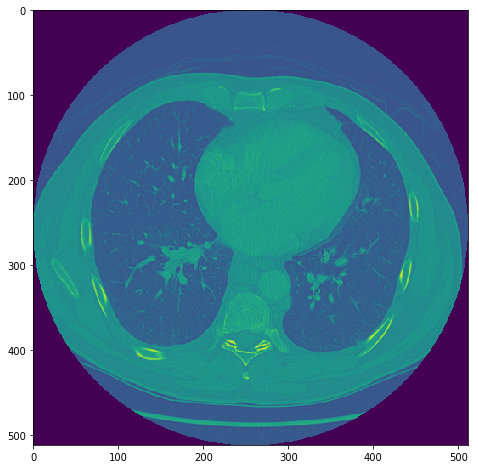

In [36]:
slice_nb = 65
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,aspect='equal')
ax.imshow(batch.images[slice_nb]);

### 2. Run preprocess on dataset and dump it

#### A. Reshaping dataset to fixed shape

It's easy to resize both a batch of images, and make resizing pipeline. First, let's see our ploted scan_id after resize:

In [37]:
batch_r = ds.create_batch([ind.indices[0]]).load('raw').resize(n_workers=6, shape=(128, 256, 256))

In [42]:
print("SCAN_ID:",batch.indices[0], '\n',
     'it\'s shape after resize is:', batch_r.images_shape[0], '\n',
     'original shape was:', batch.images_shape[0])

SCAN_ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.162718361851587451505896742103 
 it's shape after resize is: [128 256 256] 
 original shape was: [139 512 512]


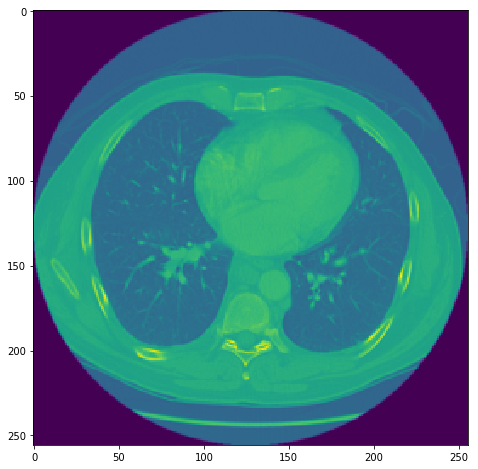

In [48]:
slice_nb = 60
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,aspect='equal')
ax.imshow(batch_r.images[slice_nb]);

Not surprisingly, it is a little bit blurry as we decreased original height and width from **`512 x 512 to 256 x 256`**


Pipeline with dumping files to disk for the full dataset would be:

In [38]:
workflow = (
    ds.pipeline()
      .load(fmt='raw')
      .resize(n_workers=6, shape=(128, 256, 256))
      .dump(dst=DIR_DUMP, components='images')
)

Note, workflow is in lazy-mode, so it is not yet running

Here you actually start preprocessing.

Note, preprocessing all LUNA16 scans may take significant time

In [ ]:
BATCH_SIZE = 8
workflow.run(batch_size=BATCH_SIZE, shuffle=False)

#### B. Unify spacing AND resize to fixed size

Sometimes it is useful to equalize spacing along different axes but still be able to handle images, e.g. for training network, which often requires same input size.

`.unify_spacing` helps here. Idea is following: 

1) Shape is changed for every scan so, that spacing would meet required **```(0.9, 0.9, 0.9)```**

2) Interim shape is cropped (if it is bigger) or padded (if it is smaller) to meet **```shape```**

In [ ]:
workflow = (
    ds.pipeline()
      .load(fmt='raw')
      .unify_spacing(shape=(384, 448, 448), spacing=(0.9, 0.9, 0.9))
      .dump(dst=DIR_DUMP, components='images')
)

Let's see how unify spacing is different from resize and original:

In [49]:
batch_u = ds.create_batch([ind.indices[0]]).load('raw').unify_spacing(shape=(384, 448, 448), spacing=(0.9, 0.9, 0.9),)

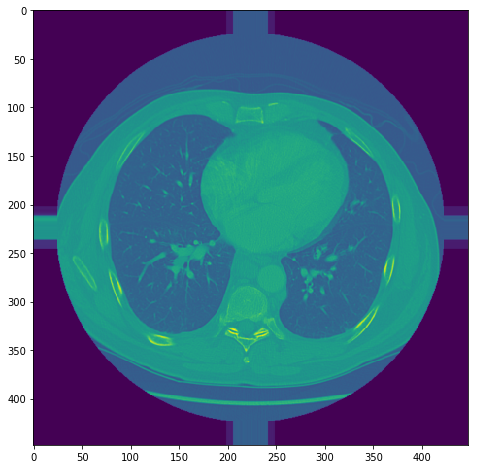

In [50]:
slice_nb = 180
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,aspect='equal')
ax.imshow(batch_u.images[slice_nb]);

You may note that image now reminds a cross due to padding default mode 'edge'. You may pass'padding' directly to `.unify_spacing`, see all padding modes supported by numpy [here](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.pad.html).

### 3. Load dumped scans, build masks

Here you need annotation file with nodules locations and diameters. 

It is also provided by LUNA16 https://luna16.grand-challenge.org/data/

In [51]:
nodules = pd.read_csv('/notebooks/data/MRT/luna/CSVFILES/annotations.csv')

ind_dumped = FilesIndex(path=DIR_DUMP + '*', dirs=True)

batch_dumped = CTIMB(ind_dumped.create_subset(ind_dumped.index[0 : 4]))

batch_dumped.load(fmt='blosc', components='images')

batch_dumped.fetch_nodules_info(nodules)

batch_dumped.create_mask()

selector_events.py[LINE:53]#DEBUG    [2017-12-14 13:49:48,487]  Using selector: EpollSelector


IndexError: index 0 is out of bounds for axis 0 with size 0

So, you just loaded 1 batch of 4 scans and made masks for it

### 4. Check the whole thing: visualise slices of scans

It is convenient to use interact for visualising various slices and masks

In [ ]:
def plot_arr_slices(height, *arrays, clim=(-1200, 300)):
    fig, axes = plt.subplots(1, len(arrays), figsize=(14, len(arrays)*8))
    
    for arr, i in zip(arrays, range(len(arrays))):
        depth = arr.shape[0]
        n_slice = int(depth * height)
        
        kwargs = dict()
        if np.max(arr) - np.min(arr) > 2.0:
            kwargs.update(clim=clim)
        else:
            kwargs.update(clim=(0, 1))
    
        axes[i].imshow(arr[n_slice], cmap=plt.cm.gray, **kwargs)
    plt.show()

Let's see the first patient scans

In [ ]:
n_pat = 0

interact(lambda height: plot_arr_slices(height, batch_dumped[n_pat], batch_dumped.get_mask(n_pat)), 
         height=(0.01, 0.99, 0.01))

### 5. Sample crops of fixed size from preprocessed scans with masks

Let's take batch we loaded and visualised and sample crops with nodules from it via ```sample_nodules``` method

In [ ]:
nods_batch = batch_masked.sample_nodules(batch_size=10, nodule_size=(32, 64, 64), share=0.7,
                                         variance=[100, 400, 400])

It creates new batch with 10 items in it, which are crops (aka patches) from original scans of size (32, 64, 64). 

However, you may want crops with nodules in different positions (not in the center of crop), for this specify ```variance``` which allows to shift center of crop to (10, 20, 20) voxels along (z, y, x) axes in example above. 

Also, for traingin neural nets, you may want to have crops without nodules at all, specify ```share``` which is share of items with nodules.